# Advanced Processing
In the previous walkthrough notebook, we got to manually inspect raw instance and do some cleaning based on annotations and creating evoked responses from time-locked events. 

In this section, we run independent component analysis (ICA) on the epochs we had from the last notebook. We look in ICs to identify potentially bad components with eye related artifcats. Then, we implement autoreject (http://autoreject.github.io) which automatically attempts to find bad channels and interpolate those based on nearby channels. At the end, we plot the ERPs by channels that we are interested in looking and make comparison. 

Note that the plots below will be using `print` statements for demonstration purposes.

In [1]:
import mne
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from mne.preprocessing import eog
from mne.preprocessing import create_eog_epochs
from mne.preprocessing.peak_finder import peak_finder
import Tkinter

from autoreject import AutoReject
from autoreject import get_rejection_threshold
from mne.preprocessing import ICA

### Loading epochs
We imported all the necessary dependencies. Now we load the saved epochs from last notebook. 

In [2]:
epochs_tlstS = mne.read_epochs('epochs_tlsts-epo.fif', preload=True)
print(epochs_tlstS)

<EpochsFIF  |   388 events (all good), -0.25 - 0.8 sec, baseline [-0.25, 0], ~72.8 MB, data loaded, with metadata,
 u'lstS': 388>


## Running Independent Component Analysis (ICA)
ICA is a signal processing method to decompose signals into independent sources from a mixed signal. A representative example is the cocktail party effect, which is a phenomenon in which you are able to concentrate on the voice of the speaker  you are conversing with regardless of the various background noise in a party. Using ICA helps seperate the different sources of mixed sound, under the assumption that the sound components are linear. This method works for EEG signal preprocessing because we assume that each electrode is independent from the others. To think of it easily, I consider ICA as decomposing the data into multiple layers, and by excluding bad ICs, we filter the data.

In [3]:
# the function calculates optimal reject threshold for ICA
reject = get_rejection_threshold(epochs_tlstS)
print(reject)

Estimating rejection dictionary for eeg
Estimating rejection dictionary for eog
{'eeg': 0.0007759871430524497, 'eog': 5.903189072009943e-05}


### Low-frequency slow drifts
Because ICA is sensitive to low-frequency slow drifts, it is recommended that 1Hz highpass filter is applied. Since this was already done to our raw instance in the previous notebook, it can be skipped. You can double check as below, or apply the highpass filter if you haven't already.

In [4]:
# double check highpass filter
print(epochs_tlstS.info['highpass'])

# epochs_tlstS.info['highpass'] = 1

1.0


### Fit ICA
Now we will run ICA on our epoch data. For simplicity and time sake, we will limit the number of components to 20 with fastICA method, which is the generally used one. The number of ICs can be created up to as many electrodes (in this case 128 - bad channels). In `ica1.fit`, we use the recommended reject threshold from Autoreject.

In [5]:
ica = ICA(n_components=20, max_pca_components=None, n_pca_components=None, noise_cov=None, 
           random_state=None, method='fastica', fit_params=None, max_iter=200, verbose=None)
print('fitting ica...')
ica.fit(epochs_tlstS, reject=reject)

fitting ica...


/Users/Jin/Library/Python/2.7/lib/python/site-packages/scipy/linalg/basic.py:1321: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  x, resids, rank, s = lstsq(a, b, cond=cond, check_finite=False)


<ICA  |  epochs decomposition, fit (fastica): 81868 samples, 20 components, channels used: "eeg">

## Artifact detection using ICA correlation
`plot_sources` can show the signals of each ICs. We can manually inspect for ICs with noise, or identify bad ICs that correlates with oscillations from eye-related channels. We use the builtin `find_bads_eog` from ICA class. 

`plot_scores` will show the correlation values for each component, and mark the ones that are potentially bad with red. Note that because we only specified 20 components, the decomposition is rather compressed. 

suggested eog component: [3]


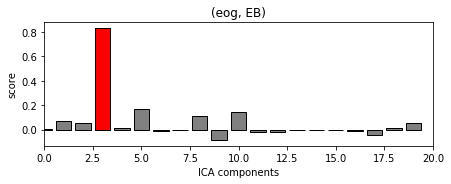

Figure(460.8x194.4)


In [6]:
eog_inds, scores = ica.find_bads_eog(epochs_tlstS)
print('suggested eog component: ' + str(eog_inds))
print(ica.plot_scores(scores, exclude=eog_inds, labels='eog'))

The `find_bads_eog` suggested that component '3' is bad IC related to eye-related artifact. We can plot that specific component to inspect manually. 

/Users/Jin/Library/Python/2.7/lib/python/site-packages/mne/transforms.py:689: RuntimeWarning: invalid value encountered in divide
  out[:, 2] = np.arccos(cart[:, 2] / out[:, 0])


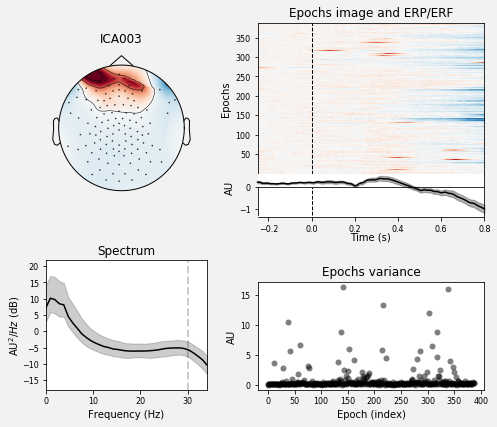

[<Figure size 504x432 with 5 Axes>]
[3]


In [7]:
print(ica.plot_properties(epochs_tlstS, picks=eog_inds, psd_args={'fmax': 35.}, image_args={'sigma': 1.}))
ica.exclude += eog_inds
print(ica.exclude)

Usually, eye blinks are characterized as having significantly polar activities between the frontal and the posterior regions with high activity in the frontal region (ie. eyes). Also, activities shown in the frontal region, especially near the eye area, would not be helpful in our analysis. Eye movements are characterized as having significantly split activities between left and right. Component above does seem containing eye blinks, we mark that component bad by `ica.exclude` and we can see that component has been added.

We can also manually inspect for other components using `plot_components` besides the ones that the builtin method suggested. You can see that the component speficied above being grayed out as a bad IC. The plot prioritizes showing ICs with large activations and polarity, which means that most of the bad ICs could be found in the early ICs.

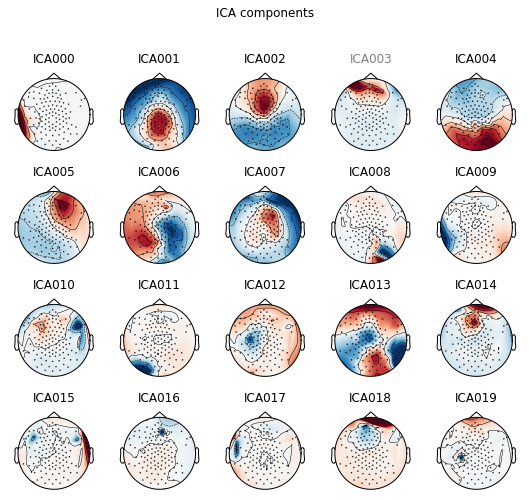

[<Figure size 540x504 with 20 Axes>]


In [8]:
print(ica.plot_components(inst=epochs_tlstS))

When running the code on `ipython` as suggested in the previous notebook, the plot is actually interactive. By clicking on the component, it shows the component properties. Clicking on the name of the component will gray out the name and be marked as bad IC. Here, it seems components 2, 14, and 18 have high activation in the eye regions, which could be identified as components with eye blinks. Also, componnent 5 has activation in the frontal region, and has polar activities between left and right, which could potentially be eye movements. Because the plot above is not interactive, we will specify which ICs to exclude as a line of code.

Since we've identified the bad ICs, we can apply it to our epochs_tlstS, and proceed to autoreject.  

In [9]:
ica.exclude += [0, 2, 5, 14, 18]
print(ica.exclude)
ica.apply(epochs_tlstS)
print('number of ICs dropped: ' + str(len(ica.exclude)))

[3, 0, 2, 5, 14, 18]
number of ICs dropped: 6


## Autoreject
Now that we have bad ICs identified, we try implementing autoreject for cleaning. Note that the step below may take some time as it tries find bad channels and fix them.

In [10]:
ar = AutoReject()
epochs_clean = ar.fit_transform(epochs_tlstS)

Running autoreject on ch_type=eeg
[........................................] 100.00% Creating augmented epochs \ Computing thresholds ...
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   13.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   16.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   19.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   21.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:   27.5s r

The above created a new epochs called `epochs_clean`. We can compare how the epochs are cleaned by comparing the two plots. For demonstration, we only plot the `epochs_clean`. The plot shows individual epochs with green line being 0 (the onset of the word in the experiment). In the interactive plot mode, you can scroll vertically to see different channels and horizontally to search through epochs.

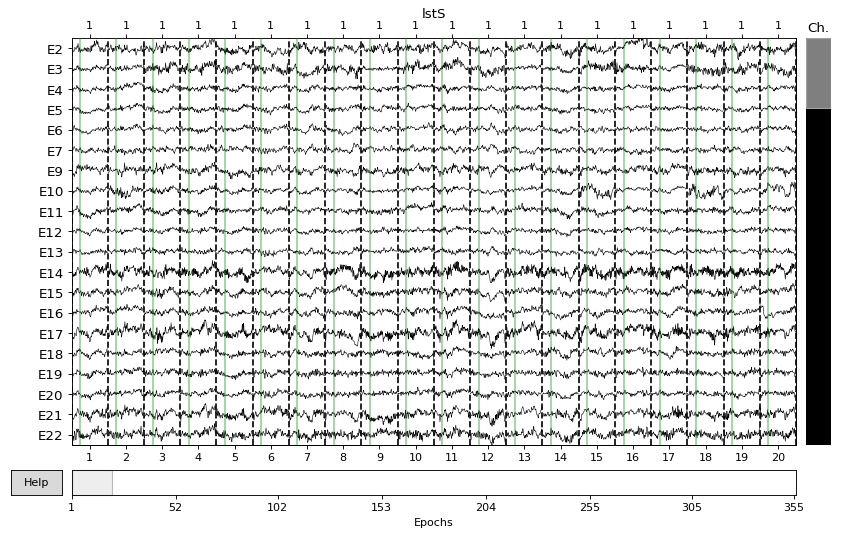

Figure(869.6x536.8)


In [11]:
print(epochs_clean.plot())

## Creating evoked response from epochs_clean
Now that we have a new, ideally cleaner epochs, we create evoked response for each condition. Currently, `epochs_clean` contains all four conditions with approximately 100 epochs for each (less than 400 now because epochs been rejected). Note that the y-axis microvolt scale has been refined compared to our previous notebook.

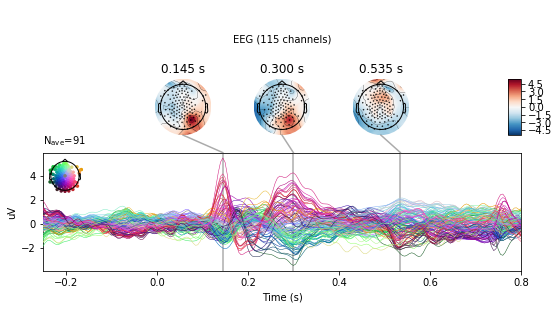

Figure(576x302.4)


In [13]:
# now let's create a new evoked responses (ie. the autoreject evoked)
arevoked_tlst_c1 = epochs_clean["label=='lstS' and cond=='1'"].average()
arevoked_tlst_c2 = epochs_clean["label=='lstS' and cond=='2'"].average()
arevoked_tlst_c3 = epochs_clean["label=='lstS' and cond=='3'"].average()
arevoked_tlst_c4 = epochs_clean["label=='lstS' and cond=='4'"].average()

# let's see a sample evoked response
print(arevoked_tlst_c1.plot_joint(times='peaks'))

## Plotting ERP comparison
Now that we have evoked response for each condition, we can look into specific channels of interest to see how the signals differ by conditions. For the selection list, we will only specify channel E92 as it will create 4 graphs for each channel. 

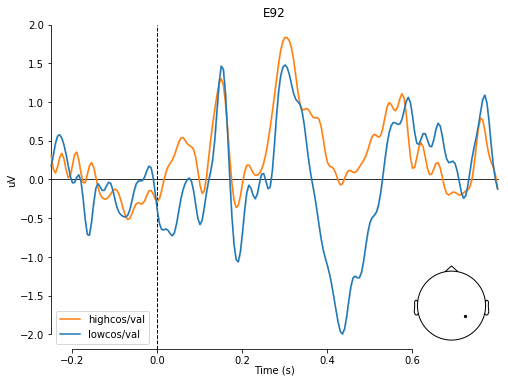

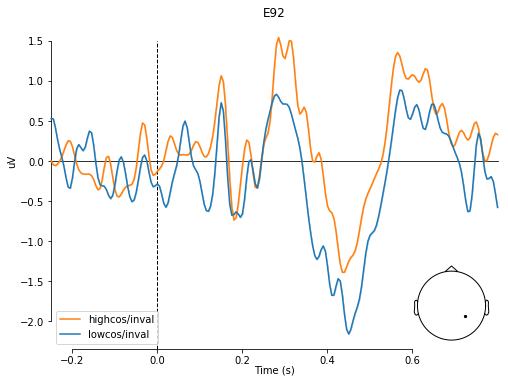

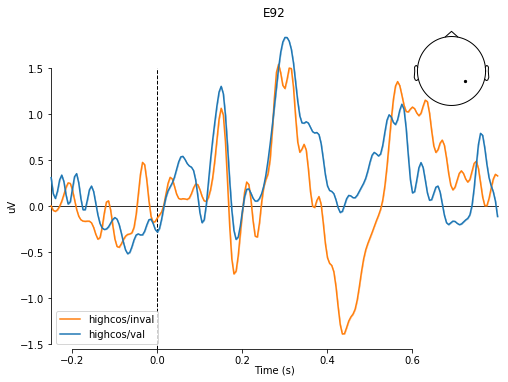

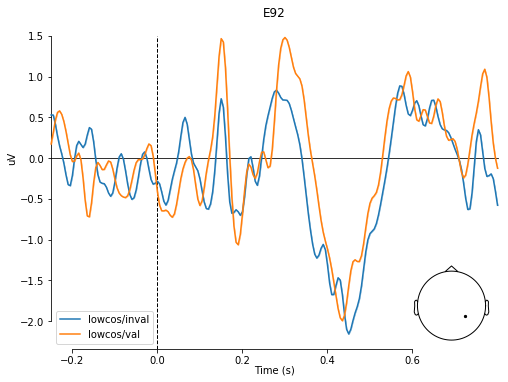

In [15]:
# we specify which channels to look at
selection = ['E92']  # ['EB','E11','E24','E124','E36','E104','E52','E62','E92']
picks_select = mne.pick_types(epochs_clean.info, meg=False, eeg=True, eog=True, stim=False, 
                              exclude='bads', selection=selection)

# create dictionary for each condition
evoked_dict = {'highcosval': arevoked_tlst_c1,
                'lowcosval': arevoked_tlst_c2,
                'highcosinval': arevoked_tlst_c3,
                'lowcosinval': arevoked_tlst_c4}

picks_select = mne.pick_types(arevoked_tlst_c1.info, meg=False, eeg=True, eog=True, stim=False, 
                              exclude='bads', selection=selection)


# this will plot each selected channel with comparison of two conditions
title = '%s_vs_%s_E%s.png'
for i in range(0, len(picks_select)):
    fig1 = mne.viz.plot_compare_evokeds({'highcos/val':evoked_dict['highcosval'], 
                                         'lowcos/val':evoked_dict['lowcosval']}, picks=picks_select[i])
    fig2 = mne.viz.plot_compare_evokeds({'highcos/inval':evoked_dict['highcosinval'], 
                                         'lowcos/inval':evoked_dict['lowcosinval']}, picks=picks_select[i])
    fig3 = mne.viz.plot_compare_evokeds({'highcos/val':evoked_dict['highcosval'], 
                                         'highcos/inval':evoked_dict['highcosinval']},picks=picks_select[i])
    fig4 = mne.viz.plot_compare_evokeds({'lowcos/val':evoked_dict['lowcosval'],
                                         'lowcos/inval':evoked_dict['lowcosinval']}, picks=picks_select[i])

    # save figs
    # fig1.savefig(title % (evoked_dict.keys()[0], evoked_dict.keys()[1], i))
    # fig2.savefig(title % (evoked_dict.keys()[2], evoked_dict.keys()[3], i))
    # fig3.savefig(title % (evoked_dict.keys()[0], evoked_dict.keys()[2], i))
    # fig4.savefig(title % (evoked_dict.keys()[1], evoked_dict.keys()[3], i))

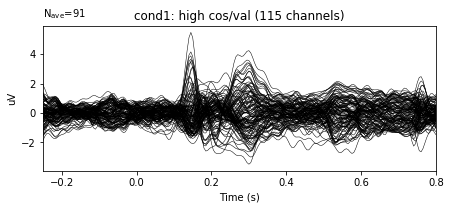

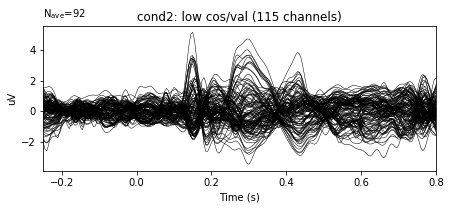

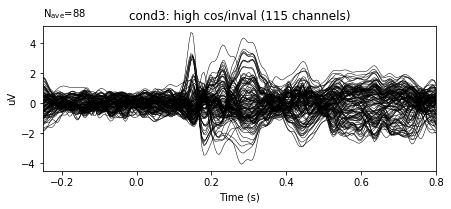

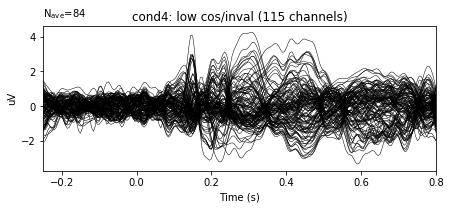

In [16]:
# this will plot just the evoked responses per conditions with all channels
fig5 = arevoked_tlst_c1.plot(titles='cond1: high cos/val')
fig6 = arevoked_tlst_c2.plot(titles='cond2: low cos/val')
fig7 = arevoked_tlst_c3.plot(titles='cond3: high cos/inval')
fig8 = arevoked_tlst_c4.plot(titles='cond4: low cos/inval')

# save figs
# fig5.savefig('c1all.png')
# fig6.savefig('c2all.png')
# fig7.savefig('c3all.png')
# fig8.savefig('c4all.png')

## Sources and useful links
EEGLab ICA guide: https://sccn.ucsd.edu/wiki/Chapter_09:_Decomposing_Data_Using_ICA

MNE ICA class: https://martinos.org/mne/stable/generated/mne.preprocessing.ICA.html

autoreject: http://autoreject.github.io/auto_examples/plot_auto_repair.html#sphx-glr-auto-examples-plot-auto-repair-py

Clemens Brunner's great guide on ICA: https://cbrnr.github.io/2018/01/29/removing-eog-ica/

Clemens Brunner's great guide on EOG detection using linear regression: https://cbrnr.github.io/2017/10/20/removing-eog-regression/

MNE stats: https://martinos.org/mne/stable/auto_tutorials/plot_stats_cluster_erp.html#sphx-glr-auto-tutorials-plot-stats-cluster-erp-py